# H bond recognition and lifetime analysis

## Import packages

In [68]:
import json
from cage_data import cage1_info
from fishmol import trj, data, dimer, style
from fishmol.utils import retrieve_symbol

In [3]:
def pop_C(TFAs):
    for TFA in TFAs:
        [TFA.pop(key) for key in list(TFA.keys()) if key == "C1" or key == "C2"] # keep F and O in TFAs only for H-bond analysis
    return TFAs

In [4]:
waters = cage1_info.waters
TFAs = cage1_info.TFAs
phenols = cage1_info.phenols
amines = cage1_info.amines
TFA_F_Os = pop_C(TFAs)
atoms_dict = waters + phenols + amines + TFA_F_Os
cell = cage1_info.cell

In [10]:
donors, acceptors = dimer.find_d_a(atoms_dict = atoms_dict)
d_a_pairs, d_h_a_pairs = dimer.pair_d_a(donors = donors, acceptors = acceptors)

Done! 40 donors and 40 acceptors were found!
Acceptors:
 [{'O': 14}, {'O': 17}, {'O': 143}, {'O': 146}, {'O': 272}, {'O': 275}, {'O': 401}, {'O': 404}, {'F1': 0, 'F2': 1, 'F3': 2, 'O1': 3, 'O2': 4}, {'F1': 7, 'F2': 8, 'F3': 9, 'O1': 10, 'O2': 11}, {'F1': 129, 'F2': 130, 'F3': 131, 'O1': 132, 'O2': 133}, {'F1': 136, 'F2': 137, 'F3': 138, 'O1': 139, 'O2': 140}, {'F1': 258, 'F2': 259, 'F3': 260, 'O1': 261, 'O2': 262}, {'F1': 265, 'F2': 266, 'F3': 267, 'O1': 268, 'O2': 269}, {'F1': 387, 'F2': 388, 'F3': 389, 'O1': 390, 'O2': 391}, {'F1': 394, 'F2': 395, 'F3': 396, 'O1': 397, 'O2': 398}] 
 Donors:
 [{'O': 14, 'H1': 15}, {'O': 14, 'H2': 16}, {'O': 17, 'H1': 18}, {'O': 17, 'H2': 19}, {'O': 143, 'H1': 144}, {'O': 143, 'H2': 145}, {'O': 146, 'H1': 147}, {'O': 146, 'H2': 148}, {'O': 272, 'H1': 273}, {'O': 272, 'H2': 274}, {'O': 275, 'H1': 276}, {'O': 275, 'H2': 277}, {'O': 401, 'H1': 402}, {'O': 401, 'H2': 403}, {'O': 404, 'H1': 405}, {'O': 404, 'H2': 406}, {'O': 24, 'H': 25}, {'O': 411, 'H': 41

In [33]:
import numpy as np

In [36]:
%%time
traj = trj.Trajectory(timestep = 5, data = "/nobackup/rhtp48/data_ana/cage1-500K.xyz", index = ":", cell = cell)

CPU times: user 2min 12s, sys: 3.19 s, total: 2min 15s
Wall time: 2min 16s


In [37]:
traj.wrap2box()

We simulated a large system with 516 atoms at very long time scale (256.9 ps), and the recognition of H bonds can take hours.

In [38]:
%%time
hbonds = dimer.res_h(d_a_pairs = d_a_pairs, d_h_a_pairs = d_h_a_pairs, frames = traj.frames)

CPU times: user 3h 38min 2s, sys: 3h 59min 28s, total: 7h 37min 30s
Wall time: 2h 35min 1s


In [39]:
with open("/nobackup/rhtp48/data_ana/results/cage1-hbonds-500K.json", "w") as json_file:
    json.dump(hbonds, json_file)
json_file.close()

## $R(\text{D} \cdot \cdot \cdot \text{A}) - \angle \text{D} - \text{H} \cdot \cdot \cdot \text{A}$ heatmap

### All H bonds

In [54]:
# Run this if you are loading data from saved json files
# Opening JSON file
f = open("/nobackup/rhtp48/data_ana/results/cage1-hbonds-500K.json")
 
# returns JSON object as a dictionary
hbonds = json.load(f)

In [40]:
# Iterating through the json list
nhbonds=[]
d_h_a_ang = []
r_d_a = []
for hbond in hbonds:
    nhbonds.append(hbond["n_hbonds"])
    a = hbond["hbonds"]
    for element in a:
        r_d_a.append(element["R(D-A)"])
        d_h_a_ang.append(element["DHA_ang"])

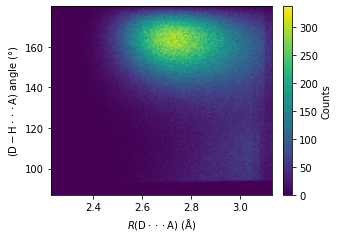

In [43]:
import matplotlib.pyplot as plt
_, ax =plt.subplots(figsize = (4.6, 3.2), constrained_layout =  True)
heatmap, xedges, yedges = np.histogram2d(np.array(r_d_a, dtype = float), np.array(d_h_a_ang, dtype = float), bins=150)

extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

im = ax.imshow(heatmap.T, extent=extent, origin='lower', aspect = "auto")
cbar = ax.figure.colorbar(im, ax = ax)
cbar.ax.set_ylabel("Counts", rotation=90, labelpad = 8.5, va="center", ha ="center")
ax.set_xlabel("$R\mathrm{(D\cdot \cdot \cdot A)}$ ($\mathrm{\AA}$)")
ax.set_ylabel("$\mathrm{(D-H\cdot \cdot \cdot A)}$ angle (°)")

plt.savefig("test/cage1-all_hbonds_angle_r_heatmap.jpg", dpi = 600)

plt.show()

### H bonds with the participance of water molecules

In [44]:
waters

({'O': 14, 'H1': 15, 'H2': 16},
 {'O': 17, 'H1': 18, 'H2': 19},
 {'O': 143, 'H1': 144, 'H2': 145},
 {'O': 146, 'H1': 147, 'H2': 148},
 {'O': 272, 'H1': 273, 'H2': 274},
 {'O': 275, 'H1': 276, 'H2': 277},
 {'O': 401, 'H1': 402, 'H2': 403},
 {'O': 404, 'H1': 405, 'H2': 406})

In [47]:
water_O = [water["O"] for water in waters]
water_O

[14, 17, 143, 146, 272, 275, 401, 404]

### Filter the H bonds resolved, keep those with the participance of a water molecules only

In [56]:
def has_common(a, b):
    a_set = set(a)
    b_set = set(b)
    if (a_set & b_set):
        return True
    else:
        return False
    
has_water_hbonds = []
for i, frame in enumerate(hbonds):
    hbonds = []
    for hbond in frame["hbonds"]:
        d_h_a = [*hbond["donor"].values(), *hbond["acceptor"].values()]
        if has_common(d_h_a, water_O):
            hbonds.append(hbond)
    has_water_hbonds.append({f"frame": i, "n_hbonds": len(hbonds), "hbonds": hbonds})

In [57]:
has_water_hbonds[0]["hbonds"]

[{'donor': {'O': 24, 'H': 25},
  'acceptor': {'O': 401},
  'R(D-A)': 2.726292124271186,
  'DHA_ang': 159.98746612853796,
  'r(D-H)': 0.9967552553430291},
 {'donor': {'O': 411, 'H': 412},
  'acceptor': {'O': 14},
  'R(D-A)': 2.726051523249053,
  'DHA_ang': 160.5043633242915,
  'r(D-H)': 1.001683650666012},
 {'donor': {'O': 153, 'H': 154},
  'acceptor': {'O': 272},
  'R(D-A)': 2.725839022339603,
  'DHA_ang': 160.58162299841513,
  'r(D-H)': 1.0020543270949314},
 {'donor': {'O': 282, 'H': 283},
  'acceptor': {'O': 143},
  'R(D-A)': 2.7011264954331087,
  'DHA_ang': 161.4098213827206,
  'r(D-H)': 0.9996765075384993},
 {'donor': {'N': 410, 'H2': 285},
  'acceptor': {'O': 404},
  'R(D-A)': 2.864580984838505,
  'DHA_ang': 164.3774626679764,
  'r(D-H)': 1.032222888114154},
 {'donor': {'N': 152, 'H2': 27},
  'acceptor': {'O': 146},
  'R(D-A)': 2.8591792887230647,
  'DHA_ang': 163.56178179798138,
  'r(D-H)': 1.032487326611596},
 {'donor': {'N': 281, 'H2': 414},
  'acceptor': {'O': 275},
  'R(D-A)'

In [61]:
with open("/nobackup/rhtp48/data_ana/results/cage1-has-water-hbonds-500K.json", "w") as json_file:
    json.dump(has_water_hbonds, json_file)
json_file.close()

In [58]:
# Iterating through the json list
nhbonds=[]
d_h_a_ang = []
r_d_a = []
for hbond in has_water_hbonds:
    nhbonds.append(hbond["n_hbonds"])
    a = hbond["hbonds"]
    for element in a:
        r_d_a.append(element["R(D-A)"])
        d_h_a_ang.append(element["DHA_ang"])

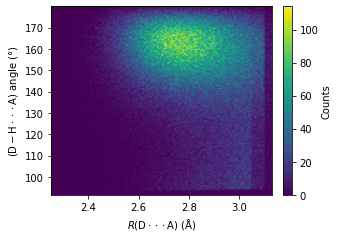

In [59]:
import matplotlib.pyplot as plt
_, ax =plt.subplots(figsize = (4.6, 3.2), constrained_layout =  True)
heatmap, xedges, yedges = np.histogram2d(np.array(r_d_a, dtype = float), np.array(d_h_a_ang, dtype = float), bins=150)

extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

im = ax.imshow(heatmap.T, extent=extent, origin='lower', aspect = "auto")
cbar = ax.figure.colorbar(im, ax = ax)
cbar.ax.set_ylabel("Counts", rotation=90, labelpad = 8.5, va="center", ha ="center")
ax.set_xlabel("$R\mathrm{(D\cdot \cdot \cdot A)}$ ($\mathrm{\AA}$)")
ax.set_ylabel("$\mathrm{(D-H\cdot \cdot \cdot A)}$ angle (°)")

plt.savefig("test/cage1-has_water_hbonds_angle_r_heatmap.jpg", dpi = 600)

plt.show()

## H bond lifetime 

### All H bonds

In [63]:
c1_t, c1_C_ts_mean, c1_C_ts_error = dimer.auto_cor(nframes = 5000, skip = 100, data = "/nobackup/rhtp48/data_ana/results/cage1-hbonds-500K.json", index = ":")
c1_C_ts_mean

array([1.        , 0.78365306, 0.64408114, 0.54720111, 0.47499348,
       0.41793104, 0.37138124, 0.33213615, 0.29868346, 0.27004558,
       0.24516531, 0.22360301, 0.20444858, 0.18752604, 0.17225393,
       0.15881247, 0.14681956, 0.13595855, 0.12599585, 0.11686875,
       0.10862518, 0.10111938, 0.09427445, 0.08796273, 0.08226667,
       0.07685842, 0.0719501 , 0.06748487, 0.06337391, 0.05956119,
       0.05602405, 0.05279543, 0.04978264, 0.0470523 , 0.04447146,
       0.04204273, 0.03980548, 0.03775526, 0.0358452 , 0.03403376,
       0.0323862 , 0.03082745, 0.02929539, 0.02784549, 0.02648702,
       0.02520094, 0.02406221, 0.02294833, 0.02187818, 0.02087655])

In [66]:
c1_x_fit, c1_y_fit, c1_params = dimer.bi_exp_fit(c1_t, c1_C_ts_mean, amp1 = 0.35922814, tau1 = 5.98152426, tau2 = 1.22001)
c1_tau = dimer.calc_tau(*c1_params)

The fitted biexponential function paramters are:
A: 0.47960248157210766, tau1: 7.086391337617406, tau2: 1.3125274137234557
The H-bond lifetime is 4.081686879882692 ps.


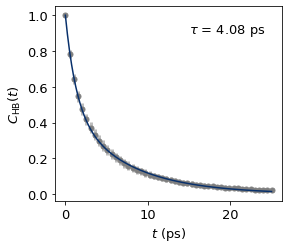

In [69]:
fig, ax = plt.subplots()

ax.errorbar(c1_t, c1_C_ts_mean, yerr = c1_C_ts_error, fmt='o', color="tab:grey",
                    ecolor='#bdbdbd', elinewidth=3, capsize=0, zorder = 0); 
ax.plot(c1_x_fit, c1_y_fit, color = "#08306b", zorder = 1)

ax.text(15.0, 0.9, r"$\tau$ = %.2f ps"%c1_tau)

# ax.xaxis.set_major_locator(MultipleLocator(5))
ax.set_xlabel("$t$ (ps)")
ax.set_ylabel("$C_{\mathrm{HB}}(t)$")
plt.savefig("test/cage1_all_hbond_lifetime_500K.jpg", dpi = 600)
plt.show()

### H bonds formed with a water molecule

In [70]:
c1_t, c1_C_ts_mean, c1_C_ts_error = dimer.auto_cor(nframes = 5000, skip = 100, data = "/nobackup/rhtp48/data_ana/results/cage1-has-water-hbonds-500K.json", index = ":")
c1_C_ts_mean

array([1.        , 0.73088204, 0.55191651, 0.43177474, 0.3470527 ,
       0.28622472, 0.23942545, 0.20259308, 0.17290821, 0.14830441,
       0.12817609, 0.11123238, 0.09693985, 0.08468134, 0.0743088 ,
       0.06540281, 0.05769645, 0.05130411, 0.04565903, 0.0402614 ,
       0.03559201, 0.03155476, 0.02801979, 0.02469743, 0.02212224,
       0.019557  , 0.01733431, 0.01537476, 0.01366477, 0.01201793,
       0.01050928, 0.00920126, 0.0080454 , 0.00710689, 0.00624038,
       0.00545512, 0.00482987, 0.00426726, 0.00380215, 0.00347118,
       0.00321754, 0.00294797, 0.00266208, 0.00236212, 0.00215375,
       0.00197273, 0.00181923, 0.00162575, 0.00146898, 0.00135168])

In [71]:
c1_x_fit, c1_y_fit, c1_params = dimer.bi_exp_fit(c1_t, c1_C_ts_mean, amp1 = 0.35922814, tau1 = 5.98152426, tau2 = 1.22001)
c1_tau = dimer.calc_tau(*c1_params)

The fitted biexponential function paramters are:
A: 0.44937016787700423, tau1: 3.9978218254149307, tau2: 1.0343073313291071
The H-bond lifetime is 2.3660223370423887 ps.


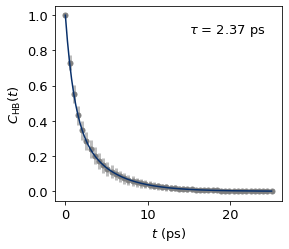

In [72]:
fig, ax = plt.subplots()

ax.errorbar(c1_t, c1_C_ts_mean, yerr = c1_C_ts_error, fmt='o', color="tab:grey",
                    ecolor='#bdbdbd', elinewidth=3, capsize=0, zorder = 0); 
ax.plot(c1_x_fit, c1_y_fit, color = "#08306b", zorder = 1)

ax.text(15.0, 0.9, r"$\tau$ = %.2f ps"%c1_tau)

ax.set_xlabel("$t$ (ps)")
ax.set_ylabel("$C_{\mathrm{HB}}(t)$")
plt.savefig("test/cage1_has_water_hbond_lifetime_500K.jpg", dpi = 600)
plt.show()